In [30]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import mdtraj as md

import torch

from snrv import Snrv

In [31]:
traj = md.load("../traj_2000_2500.dcd", top="../aib9.gro")
biasing_atom_ids = np.array([atom.index for atom in traj.topology.atoms if atom.residue.name != 'HOH'])
feat_indices = np.array([atom.index for atom in traj.topology.atoms if (atom.name == 'CA' or atom.name == 'CAY' or atom.name == 'CAT')])
pos = torch.from_numpy(traj.xyz)
box = torch.from_numpy(np.asarray([np.diag(i) for i in traj.unitcell_vectors])).view(-1, 1, 3)

In [32]:
def generate_pair_indices_from_list(index_list):
    i_list = []
    j_list = []
    for i in range(len(index_list)):
        for j in range(i + 1, len(index_list)):
            i_list.append(index_list[i])
            j_list.append(index_list[j])
    return torch.tensor(i_list), torch.tensor(j_list)

In [33]:
i_list_d, j_list_d = generate_pair_indices_from_list(feat_indices)

In [34]:
def compute_mic_dist(pos, box, i, j):
    d = pos[:, i, :] - pos[:, j, :]  # shape: [T, M, 3]
    d = d - box * torch.round(d / box)  # apply MIC
    return torch.norm(d, dim=-1)  # shape: [T, M]

In [35]:
traj_x_d = compute_mic_dist(pos, box, i_list_d, j_list_d)

In [36]:
def generate_angle_indices_from_list(index_list):
    i_list = []
    j_list = []
    k_list = []
    for j in range(len(index_list)):
        for i in range(len(index_list)):
            if i == j:
                continue
            for k in range(i + 1, len(index_list)):
                if k == j:
                    continue
                i_list.append(index_list[i])
                j_list.append(index_list[j])
                k_list.append(index_list[k])
    return torch.tensor(i_list), torch.tensor(j_list), torch.tensor(k_list)

In [37]:
i_list_a, j_list_a, k_list_a = generate_angle_indices_from_list(feat_indices)

In [38]:
def compute_mic_angles(pos, box, i, j, k):
    # pos: [T, N, 3]
    # box: [T, 1, 3]
    # i, j, k: [M]
    
    # MIC vector: ri - rj
    v1 = pos[:, i, :] - pos[:, j, :]  # [T, M, 3]
    v1 = v1 - box * torch.round(v1 / box)

    # MIC vector: rk - rj
    v2 = pos[:, k, :] - pos[:, j, :]
    v2 = v2 - box * torch.round(v2 / box)

    # Normalize
    v1_norm = torch.nn.functional.normalize(v1, dim=-1)
    v2_norm = torch.nn.functional.normalize(v2, dim=-1)

    # Dot product and angle
    cos_theta = (v1_norm * v2_norm).sum(dim=-1).clamp(-1.0, 1.0)
    angles = torch.acos(cos_theta)  # [T, M], in radians

    return angles

In [39]:
traj_x_a = compute_mic_angles(pos, box, i_list_a, j_list_a, k_list_a)

In [40]:
traj_x_d.shape

torch.Size([10000, 55])

In [41]:
traj_x_a.shape

torch.Size([10000, 495])

In [11]:
traj_x = torch.concat([traj_x_d, traj_x_a], dim=1)

In [12]:
traj_x.shape

torch.Size([10000, 550])

In [13]:
input_size = traj_x.size()[1]
output_size = 3
hidden_depth = 3
hidden_size = 1000
batch_norm = True
dropout_rate = 0.
lr = 1E-5
weight_decay = 0.
val_frac = 0.20
n_epochs = 50
batch_size = 1000
VAMPdegree = 2
is_reversible = True
num_workers = 0

model = Snrv(input_size, output_size, hidden_depth=hidden_depth, hidden_size=hidden_size,
            batch_norm=batch_norm, dropout_rate=dropout_rate, lr=lr, weight_decay=weight_decay, 
            val_frac=val_frac, n_epochs=n_epochs, batch_size=batch_size, 
            VAMPdegree=VAMPdegree, is_reversible=is_reversible, num_workers=num_workers, device="cuda")
model = model.to("cuda")

In [14]:
lag = 1
model.fit(traj_x, lag)
model.save_model(f'snrv_{lag}.pt')

Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 23.38batch/s]


[Epoch 0]	 training loss = -2.154	 validation loss = -2.446


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 56.50batch/s]


[Epoch 1]	 training loss = -2.508	 validation loss = -2.586


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 57.37batch/s]


[Epoch 2]	 training loss = -2.628	 validation loss = -2.638


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 53.20batch/s]


[Epoch 3]	 training loss = -2.679	 validation loss = -2.666


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 55.29batch/s]


[Epoch 4]	 training loss = -2.707	 validation loss = -2.683


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 34.47batch/s]


[Epoch 5]	 training loss = -2.726	 validation loss = -2.696


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 56.08batch/s]


[Epoch 6]	 training loss = -2.739	 validation loss = -2.704


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 55.99batch/s]


[Epoch 7]	 training loss = -2.752	 validation loss = -2.711


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 55.06batch/s]


[Epoch 8]	 training loss = -2.763	 validation loss = -2.716


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 56.50batch/s]


[Epoch 9]	 training loss = -2.772	 validation loss = -2.720


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 56.10batch/s]


[Epoch 10]	 training loss = -2.780	 validation loss = -2.724


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 55.69batch/s]


[Epoch 11]	 training loss = -2.787	 validation loss = -2.727


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 34.49batch/s]


[Epoch 12]	 training loss = -2.794	 validation loss = -2.730


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 55.98batch/s]


[Epoch 13]	 training loss = -2.802	 validation loss = -2.732


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 56.25batch/s]


[Epoch 14]	 training loss = -2.806	 validation loss = -2.734


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 56.23batch/s]


[Epoch 15]	 training loss = -2.813	 validation loss = -2.736


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 55.13batch/s]


[Epoch 16]	 training loss = -2.819	 validation loss = -2.737


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 56.20batch/s]


[Epoch 17]	 training loss = -2.825	 validation loss = -2.738


Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 56.68batch/s]


[Epoch 18]	 training loss = -2.830	 validation loss = -2.738


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 34.80batch/s]


[Epoch 19]	 training loss = -2.835	 validation loss = -2.739


Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 54.29batch/s]


[Epoch 20]	 training loss = -2.840	 validation loss = -2.739


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 56.01batch/s]


[Epoch 21]	 training loss = -2.845	 validation loss = -2.739


Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 55.36batch/s]


[Epoch 22]	 training loss = -2.850	 validation loss = -2.738


Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 54.93batch/s]


[Epoch 23]	 training loss = -2.855	 validation loss = -2.738


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 55.25batch/s]


[Epoch 24]	 training loss = -2.859	 validation loss = -2.738


Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 52.29batch/s]


[Epoch 25]	 training loss = -2.863	 validation loss = -2.738


Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 55.64batch/s]


[Epoch 26]	 training loss = -2.867	 validation loss = -2.736


Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 56.53batch/s]


[Epoch 27]	 training loss = -2.872	 validation loss = -2.736


Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 56.72batch/s]


[Epoch 28]	 training loss = -2.875	 validation loss = -2.735


Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 56.85batch/s]


[Epoch 29]	 training loss = -2.878	 validation loss = -2.734


Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 57.68batch/s]


[Epoch 30]	 training loss = -2.882	 validation loss = -2.734


Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 56.71batch/s]


[Epoch 31]	 training loss = -2.887	 validation loss = -2.733


Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 55.50batch/s]


[Epoch 32]	 training loss = -2.888	 validation loss = -2.732


Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 56.56batch/s]


[Epoch 33]	 training loss = -2.892	 validation loss = -2.732


Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 35.13batch/s]


[Epoch 34]	 training loss = -2.895	 validation loss = -2.729


Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 56.95batch/s]


[Epoch 35]	 training loss = -2.897	 validation loss = -2.729


Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 56.35batch/s]


[Epoch 36]	 training loss = -2.902	 validation loss = -2.728


Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 57.40batch/s]


[Epoch 37]	 training loss = -2.904	 validation loss = -2.726


Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 57.56batch/s]


[Epoch 38]	 training loss = -2.907	 validation loss = -2.724


Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 57.25batch/s]


[Epoch 39]	 training loss = -2.910	 validation loss = -2.724


Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 57.49batch/s]


[Epoch 40]	 training loss = -2.913	 validation loss = -2.723


Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 35.71batch/s]


[Epoch 41]	 training loss = -2.915	 validation loss = -2.721


Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 55.13batch/s]


[Epoch 42]	 training loss = -2.918	 validation loss = -2.720


Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 57.01batch/s]


[Epoch 43]	 training loss = -2.920	 validation loss = -2.718


Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 57.59batch/s]


[Epoch 44]	 training loss = -2.922	 validation loss = -2.717


Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 57.35batch/s]


[Epoch 45]	 training loss = -2.924	 validation loss = -2.716


Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 55.40batch/s]


[Epoch 46]	 training loss = -2.926	 validation loss = -2.715


Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 55.81batch/s]


[Epoch 47]	 training loss = -2.928	 validation loss = -2.714


Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 33.38batch/s]


[Epoch 48]	 training loss = -2.931	 validation loss = -2.713


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 53.80batch/s]


[Epoch 49]	 training loss = -2.932	 validation loss = -2.712


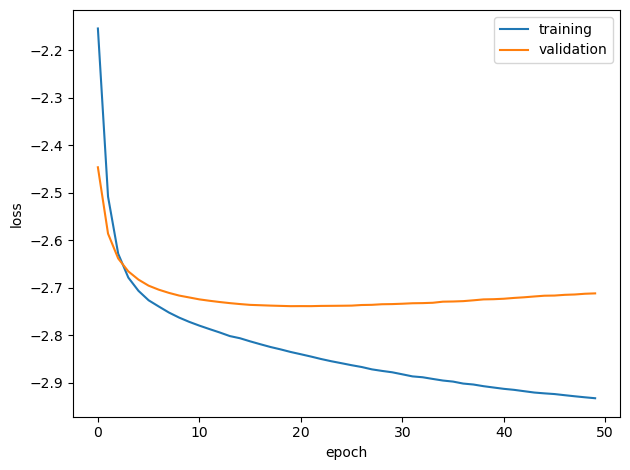

In [15]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(model.training_losses)), model.training_losses)
ax.plot(np.arange(len(model.validation_losses)), model.validation_losses)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['training','validation'])
fig.tight_layout()

In [16]:
evecs_SRV_unbiased = model.transform(traj_x.float()).cpu().detach().numpy()

In [17]:
dataset = pd.DataFrame(evecs_SRV_unbiased, columns=["TIC0", "TIC1", "TIC2"])
px.scatter(dataset, x="TIC1", y="TIC2", width=600, height=600)

In [18]:
print(dataset.max())
print(dataset.min())

TIC0    2.018538
TIC1    2.140771
TIC2    2.662255
dtype: float32
TIC0    0.843917
TIC1   -2.076475
TIC2   -2.085465
dtype: float32


In [42]:
class CV(torch.nn.Module):
    def __init__(self, model, idx):
        super().__init__()
        self.model = model
        self.idx = idx
        self.register_buffer("i_list_d", i_list_d)
        self.register_buffer("j_list_d", j_list_d)
        self.register_buffer("i_list_a", i_list_a)
        self.register_buffer("j_list_a", j_list_a)
        self.register_buffer("k_list_a", k_list_a)

    def compute_mic_dist(self, pos, box):
        d = pos[self.i_list_d, :] - pos[self.j_list_d, :]  # shape: [T, M, 3]
        d = d - box * torch.round(d / box)  # apply MIC
        return torch.norm(d, dim=-1)  # shape: [T, M]
    
    def compute_mic_angles(self, pos, box):
        # pos: [T, N, 3]
        # box: [T, 1, 3]
        # i, j, k: [M]
        
        # MIC vector: ri - rj
        v1 = pos[self.i_list_a, :] - pos[self.j_list_a, :]  # [T, M, 3]
        v1 = v1 - box * torch.round(v1 / box)

        # MIC vector: rk - rj
        v2 = pos[self.k_list_a, :] - pos[self.j_list_a, :]
        v2 = v2 - box * torch.round(v2 / box)

        # Normalize
        v1_norm = torch.nn.functional.normalize(v1, dim=-1)
        v2_norm = torch.nn.functional.normalize(v2, dim=-1)

        # Dot product and angle
        cos_theta = (v1_norm * v2_norm).sum(dim=-1).clamp(-1.0, 1.0)
        angles = torch.acos(cos_theta)  # [T, M], in radians

        return angles

    def forward(self, positions, boxvectors):
        """The forward method returns the energy computed from positions.

        Parameters
        ----------
        positions : torch.Tensor with shape (nparticles, 3)
           positions[i,k] is the position (in nanometers) of spatial dimension k of particle i

        Returns
        -------
        potential : torch.Scalar
           The potential energy (in kJ/mol)
        """
        boxsize = boxvectors.diag()
        feat_d = self.compute_mic_dist(positions, boxsize)
        feat_a = self.compute_mic_angles(positions, boxsize)
        feats = torch.concat([feat_d, feat_a])
        evecs = self.model.transform(feats.view(1, -1))
        CV = evecs[0][self.idx]
        return CV

model_output_1 = CV(model, 1)
model_output_2 = CV(model, 2)

torch.jit.script(model_output_1).save('cv1.pt')
torch.jit.script(model_output_2).save('cv2.pt')